# Mod 2 Summative Project - Soccer Match DB Transfer and Analysis

In [1]:
import sqlite3
import pymongo
import numpy as np
import json
import requests
import pandas as pd
import datetime
from pandasql import sqldf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
conn = sqlite3.connect('database.sqlite')
c = conn.cursor()

In [3]:
c.execute("""SELECT *
             FROM Matches
             WHERE Season IN (2011) AND Div IN ('D1','D2') 
             ORDER BY Date
             """)

df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
df

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1133,D2,2011,2011-07-15,Cottbus,Dresden,2,1,H
1,1167,D2,2011,2011-07-15,Greuther Furth,Ein Frankfurt,2,3,A
2,1551,D2,2011,2011-07-15,Frankfurt FSV,Union Berlin,1,1,D
3,1550,D2,2011,2011-07-16,Erzgebirge Aue,Aachen,1,0,H
4,1678,D2,2011,2011-07-16,St Pauli,Ingolstadt,2,0,H
5,1146,D2,2011,2011-07-17,Karlsruhe,Duisburg,3,2,H
6,1442,D2,2011,2011-07-17,Braunschweig,Munich 1860,3,1,H
7,1602,D2,2011,2011-07-17,Hansa Rostock,Paderborn,1,2,A
8,1360,D2,2011,2011-07-18,Fortuna Dusseldorf,Bochum,2,0,H
9,1505,D2,2011,2011-07-22,Duisburg,Cottbus,1,2,A


In [4]:
df.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1133,D2,2011,2011-07-15,Cottbus,Dresden,2,1,H
1,1167,D2,2011,2011-07-15,Greuther Furth,Ein Frankfurt,2,3,A
2,1551,D2,2011,2011-07-15,Frankfurt FSV,Union Berlin,1,1,D
3,1550,D2,2011,2011-07-16,Erzgebirge Aue,Aachen,1,0,H
4,1678,D2,2011,2011-07-16,St Pauli,Ingolstadt,2,0,H


In [5]:
def sum_goals(team,home_or_away):
    if home_or_away == 'home':
        return df.groupby('HomeTeam')['FTHG'].sum().loc[team]
    else:
        return df.groupby('AwayTeam')['FTAG'].sum().loc[team]

In [6]:
df['tot_home_goals'] = df.HomeTeam.apply(lambda team: sum_goals(team,'home'))
df.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,tot_home_goals
0,1133,D2,2011,2011-07-15,Cottbus,Dresden,2,1,H,18
1,1167,D2,2011,2011-07-15,Greuther Furth,Ein Frankfurt,2,3,A,46
2,1551,D2,2011,2011-07-15,Frankfurt FSV,Union Berlin,1,1,D,20
3,1550,D2,2011,2011-07-16,Erzgebirge Aue,Aachen,1,0,H,19
4,1678,D2,2011,2011-07-16,St Pauli,Ingolstadt,2,0,H,36


In [7]:
dict_of_win = {}
for i in list(df.AwayTeam.unique()):
    dict_of_win.update({i: 0})
for n in range(len(df)):
    if df.FTR.iloc[n] == 'H':
        dict_of_win[df.HomeTeam.iloc[n]] += 1
    elif df.FTR.iloc[n] == 'A':
        dict_of_win[df.AwayTeam.iloc[n]] += 1
dict_of_win

{'Dresden': 12,
 'Ein Frankfurt': 20,
 'Union Berlin': 14,
 'Aachen': 6,
 'Ingolstadt': 8,
 'Duisburg': 10,
 'Munich 1860': 17,
 'Paderborn': 17,
 'Bochum': 10,
 'Cottbus': 8,
 'Erzgebirge Aue': 8,
 'Frankfurt FSV': 7,
 'Karlsruhe': 9,
 'Greuther Furth': 20,
 'Hansa Rostock': 5,
 'Braunschweig': 10,
 'Fortuna Dusseldorf': 16,
 'St Pauli': 18,
 'Hamburg': 8,
 'Freiburg': 10,
 'Kaiserslautern': 4,
 'Nurnberg': 12,
 'Schalke 04': 20,
 'Wolfsburg': 13,
 'Hoffenheim': 10,
 'Leverkusen': 15,
 "M'gladbach": 17,
 'Bayern Munich': 23,
 'Dortmund': 25,
 'FC Koln': 8,
 'Stuttgart': 15,
 'Hannover': 12,
 'Hertha': 7,
 'Mainz': 9,
 'Werder Bremen': 11,
 'Augsburg': 8}

In [10]:
dict_of_loss = {}
for i in list(df.AwayTeam.unique()):
    dict_of_loss.update({i: 0})
for n in range(len(df)):
    if df.FTR.iloc[n] == 'H':
        dict_of_loss[df.AwayTeam.iloc[n]] += 1
    elif df.FTR.iloc[n] == 'A':
        dict_of_loss[df.HomeTeam.iloc[n]] += 1
dict_of_loss

{'Dresden': 13,
 'Ein Frankfurt': 6,
 'Union Berlin': 14,
 'Aachen': 15,
 'Ingolstadt': 13,
 'Duisburg': 15,
 'Munich 1860': 11,
 'Paderborn': 7,
 'Bochum': 17,
 'Cottbus': 15,
 'Erzgebirge Aue': 15,
 'Frankfurt FSV': 13,
 'Karlsruhe': 19,
 'Greuther Furth': 4,
 'Hansa Rostock': 17,
 'Braunschweig': 9,
 'Fortuna Dusseldorf': 4,
 'St Pauli': 8,
 'Hamburg': 14,
 'Freiburg': 14,
 'Kaiserslautern': 19,
 'Nurnberg': 16,
 'Schalke 04': 10,
 'Wolfsburg': 16,
 'Hoffenheim': 13,
 'Leverkusen': 10,
 "M'gladbach": 8,
 'Bayern Munich': 7,
 'Dortmund': 3,
 'FC Koln': 20,
 'Stuttgart': 11,
 'Hannover': 10,
 'Hertha': 17,
 'Mainz': 13,
 'Werder Bremen': 14,
 'Augsburg': 12}

In [12]:
dict_of_draw = {}
for i in list(df.AwayTeam.unique()):
    dict_of_draw.update({i: 0})
for n in range(len(df)):
    if df.FTR.iloc[n] == 'D':
        dict_of_draw[df.AwayTeam.iloc[n]] += 1
        dict_of_draw[df.HomeTeam.iloc[n]] += 1
dict_of_draw

{'Dresden': 9,
 'Ein Frankfurt': 8,
 'Union Berlin': 6,
 'Aachen': 13,
 'Ingolstadt': 13,
 'Duisburg': 9,
 'Munich 1860': 6,
 'Paderborn': 10,
 'Bochum': 7,
 'Cottbus': 11,
 'Erzgebirge Aue': 11,
 'Frankfurt FSV': 14,
 'Karlsruhe': 6,
 'Greuther Furth': 10,
 'Hansa Rostock': 12,
 'Braunschweig': 15,
 'Fortuna Dusseldorf': 14,
 'St Pauli': 8,
 'Hamburg': 12,
 'Freiburg': 10,
 'Kaiserslautern': 11,
 'Nurnberg': 6,
 'Schalke 04': 4,
 'Wolfsburg': 5,
 'Hoffenheim': 11,
 'Leverkusen': 9,
 "M'gladbach": 9,
 'Bayern Munich': 4,
 'Dortmund': 6,
 'FC Koln': 6,
 'Stuttgart': 8,
 'Hannover': 12,
 'Hertha': 10,
 'Mainz': 12,
 'Werder Bremen': 9,
 'Augsburg': 14}

In [8]:
df['tot_home_win'] = df.HomeTeam.apply(lambda team: dict_of_win[team])
df.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,tot_home_goals,tot_home_win
0,1133,D2,2011,2011-07-15,Cottbus,Dresden,2,1,H,18,8
1,1167,D2,2011,2011-07-15,Greuther Furth,Ein Frankfurt,2,3,A,46,20
2,1551,D2,2011,2011-07-15,Frankfurt FSV,Union Berlin,1,1,D,20,7
3,1550,D2,2011,2011-07-16,Erzgebirge Aue,Aachen,1,0,H,19,8
4,1678,D2,2011,2011-07-16,St Pauli,Ingolstadt,2,0,H,36,18


In [11]:
df['tot_home_loss'] = df.HomeTeam.apply(lambda team: dict_of_loss[team])
df.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,tot_home_goals,tot_home_win,tot_home_loss
0,1133,D2,2011,2011-07-15,Cottbus,Dresden,2,1,H,18,8,15
1,1167,D2,2011,2011-07-15,Greuther Furth,Ein Frankfurt,2,3,A,46,20,4
2,1551,D2,2011,2011-07-15,Frankfurt FSV,Union Berlin,1,1,D,20,7,13
3,1550,D2,2011,2011-07-16,Erzgebirge Aue,Aachen,1,0,H,19,8,15
4,1678,D2,2011,2011-07-16,St Pauli,Ingolstadt,2,0,H,36,18,8


In [13]:
df['tot_home_draw'] = df.HomeTeam.apply(lambda team: dict_of_draw[team])
df.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,tot_home_goals,tot_home_win,tot_home_loss,tot_home_draw
0,1133,D2,2011,2011-07-15,Cottbus,Dresden,2,1,H,18,8,15,11
1,1167,D2,2011,2011-07-15,Greuther Furth,Ein Frankfurt,2,3,A,46,20,4,10
2,1551,D2,2011,2011-07-15,Frankfurt FSV,Union Berlin,1,1,D,20,7,13,14
3,1550,D2,2011,2011-07-16,Erzgebirge Aue,Aachen,1,0,H,19,8,15,11
4,1678,D2,2011,2011-07-16,St Pauli,Ingolstadt,2,0,H,36,18,8,8


In [21]:
df_goals_wins = df.groupby('HomeTeam')[['tot_home_goals', 'tot_home_win', 'tot_home_loss', 'tot_home_draw']].first()
df_goals_wins.head()

,tot_home_goals,tot_home_win,tot_home_loss,tot_home_draw
HomeTeam,,,,
Aachen,15,6,15,13
Augsburg,20,8,12,14
Bayern Munich,49,23,7,4
Bochum,23,10,17,7
Braunschweig,21,10,9,15


In [61]:
cols = ['tot_home_win', 'tot_home_loss', 'tot_home_draw']
bar_x = ['2011_Win', '2011_Loss', '2011_Draw']

for i in range(len(df_goals_wins)):
    bar_y = list(df_goals_wins[cols].iloc[i])
    team_name = df_goals_wins.index[i]
    plt.bar(x=bar_x, height=bar_y)
    plt.title(team_name)
    plt.savefig('hist_images/{}.png'.format(team_name))
    plt.clf()

<Figure size 432x288 with 0 Axes>

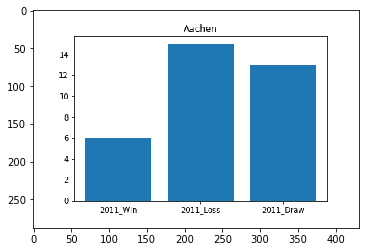

In [67]:
import matplotlib.image as mpimg
from IPython.display import Image, HTML

# df_goals_wins['graph'] = [mpimg.imread('hist_images/{}.png'.format(team_name)) for team_name in df_goals_wins.index]
# df_goals_wins.graph.iloc[0] = mpimg.imread('hist_images/Aachen.png')
df_goals_wins.graph.iloc[0]
img = mpimg.imread('hist_images/Aachen.png')
plt.imshow(img)

# df_goals_wins.head()
# HTML(df_goals_wins.to_html(escape=False))

In [82]:
from PIL import Image
from IPython.display import HTML

df_goals_wins['graph'] = [Image.open('hist_images/{}.png'.format(team_name)) for team_name in df_goals_wins.index]
df_goals_wins.head()
# HTML(df_goals_wins.to_html(escape=False))
# [Image.open('hist_images/{}.png'.format(team_name)) for team_name in df_goals_wins.index][0]

,tot_home_goals,tot_home_win,tot_home_loss,tot_home_draw,graph
HomeTeam,,,,,
Aachen,15,6,15,13,<PIL.PngImagePlugin.PngImageFile image mode=RG...
Augsburg,20,8,12,14,<PIL.PngImagePlugin.PngImageFile image mode=RG...
Bayern Munich,49,23,7,4,<PIL.PngImagePlugin.PngImageFile image mode=RG...
Bochum,23,10,17,7,<PIL.PngImagePlugin.PngImageFile image mode=RG...
Braunschweig,21,10,9,15,<PIL.PngImagePlugin.PngImageFile image mode=RG...


In [83]:
from PIL import Image
from IPython.display import HTML

df_goals_wins['graph'] = ['<img src="hist_images/{}.png"/>'.format(team_name) for team_name in df_goals_wins.index]
HTML(df_goals_wins.to_html(escape=False))

,tot_home_goals,tot_home_win,tot_home_loss,tot_home_draw,graph
HomeTeam,,,,,
Aachen,15,6,15,13,
Augsburg,20,8,12,14,
Bayern Munich,49,23,7,4,
Bochum,23,10,17,7,
Braunschweig,21,10,9,15,
Cottbus,18,8,15,11,
Dortmund,44,25,3,6,
Dresden,30,12,13,9,
Duisburg,23,10,15,9,


In [ ]:
# The name of the team
# The total number of goals scored by the team during the 2011 season
# The total number of wins the team earned during the 2011 season
# A histogram visualization of the team's wins and losses for the 2011 season (store the visualization directly)
# The team's win percentage on days where it was raining during games in the 2011 season.

In [ ]:
# Query the SQL database
# Calculate summary statistics
# Get the weather data from the DarkSky API
# Load the data into MongoDB

In [ ]:
class WeatherGetter():
    pass

In [ ]:
class MongoHandler():
    pass

In [ ]:
berlin_coordinates = 52.5200, 13.4050

In [ ]:
c.execute("""SELECT contactFirstName, contactLastName, phone, addressLine1, creditLimit
             FROM customers
             WHERE state = 'CA'
             AND creditLimit > 25000""")
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
df

In [ ]:
# df['tot_away_goals'] = df.AwayTeam.apply(lambda team: sum_goals(team,'away'))
# df.head()

In [ ]:
# df.groupby('HomeTeam').FTR.map({'H':1, 'A':0, 'D':0}).sum()

In [ ]:
c.close()
conn.close()